# ECE590: Smart Cameras Homework 4
## Nathan Inkawhich
**Duke University Spring 2019**

This notebook contains the code for training and validating the DNN focus step estimator model.

## Standard imports

In [1]:
# Helper Libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.morphology import disk
import math
import scipy

# Keras Stuff
import multiprocessing as mp
import keras
import keras.callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras.optimizers as optimizers
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

print(K.tensorflow_backend._get_available_gpus())

from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Connect to Google drive and load data

There are two things we need: 1) the HD image dataset and 2) the focus calibration data so we can create the training set. The images used here are from: https://data.vision.ee.ethz.ch/cvl/DIV2K/

In [2]:
# Set path to dataset root directory
#DATA_ROOT = "drive/My Drive/Kodak_Images"
DATA_ROOT = "drive/My Drive/DIV2K_train_HR"

# List files in data root directory
img_list = os.listdir(DATA_ROOT)
print("List of HR Images:\n",img_list)
print("Total Number of Images: ",len(img_list))

List of HR Images:
 ['0298.png', '0267.png', '0273.png', '0065.png', '0071.png', '0059.png', '0111.png', '0105.png', '0139.png', '0313.png', '0307.png', '0306.png', '0312.png', '0104.png', '0110.png', '0058.png', '0070.png', '0064.png', '0266.png', '0299.png', '0270.png', '0264.png', '0258.png', '0099.png', '0072.png', '0066.png', '0106.png', '0112.png', '0304.png', '0310.png', '0339.png', '0311.png', '0305.png', '0113.png', '0107.png', '0067.png', '0073.png', '0098.png', '0259.png', '0265.png', '0271.png', '0249.png', '0275.png', '0261.png', '0088.png', '0077.png', '0063.png', '0103.png', '0117.png', '0329.png', '0315.png', '0314.png', '0300.png', '0328.png', '0116.png', '0102.png', '0062.png', '0076.png', '0089.png', '0260.png', '0274.png', '0248.png', '0289.png', '0262.png', '0276.png', '0048.png', '0060.png', '0074.png', '0128.png', '0114.png', '0100.png', '0316.png', '0302.png', '0303.png', '0317.png', '0101.png', '0115.png', '0129.png', '0075.png', '0061.png', '0049.png', '0277.p

**Sample images from the dataset**

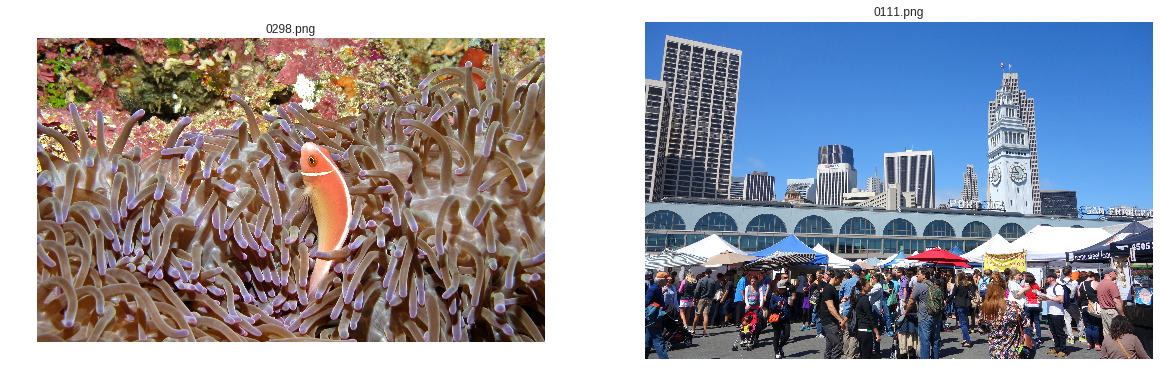

In [3]:
# Plot some sample images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(plt.imread(DATA_ROOT+"/"+img_list[0]))
plt.title(img_list[0])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(plt.imread(DATA_ROOT+"/"+img_list[6]))
plt.title(img_list[6])
plt.axis("off")
plt.show()

**Defocus data calibrated to the lab cameras**

In [4]:
deFocusModel = loadmat('drive/My Drive/defocus.mat')["defocus_model"]
print(deFocusModel.shape)

(210, 4)


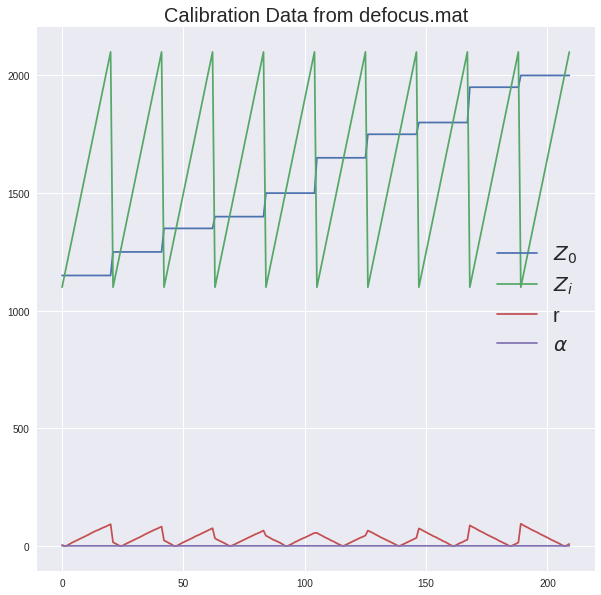

In [5]:
plt.figure(figsize=(10,10))
plt.plot(deFocusModel)
plt.legend(["$Z_0$","$Z_i$","r","$\\alpha$"],fontsize=20)
plt.title("Calibration Data from defocus.mat",fontsize=20)
plt.show()

## Prepare training dataset

The main objective of this homework is to train a regression model to look at an image and output how far (scalar quantity) to move the focus motor to properly focus the image. Since this is a supervised algorithm we need to create pairs of images and distances. The process for creating the training dataset will be as follows:

```
For each full image the the HD dataset
  grab random 512x512 crop from the center of the image
  For i=1...N
    randomly select a (Z_0,Z_i,r,alpha) point from defocus mat
    manually defocus the 512x512 image with a disk filter of radius r
    crop out the center 256x256
    save (defocusImg, abs(Z_0-Z_i)) as a training sample
```

Note, filtering the 512x512 image then center cropping the 256x256 avoids artifacts that may come with convolving a big filter with a zero padded image.

**Manual Defocus Algorithm**

First, we can write the manual defocus algorithm and see that it works. This algorithm is as follows

```
Given: img, radius, gamma
1. Create a binary disk filter with input radius
2. Fill in the values of the filter with 1/(pi*r^2)
3. Convolve the img with the disk filter. 
  - implicitly, before convolution, encode img with gamma correction and after convolution decode back to image space

```

Disk Shape:  (41, 41)
Disk max:  0.0007957747154594767
Disk min:  0.0
Image Shape:  (3, 1224, 2040)
Disk Filter Shape:  (1, 41, 41)
Output Shape:  (3, 1224, 2040)
img.max:  1.0
img.min:  0.0
Out.max:  0.99639106
Out.min:  0.003045789


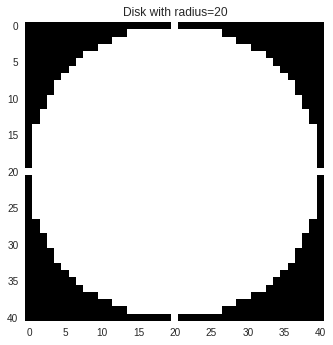

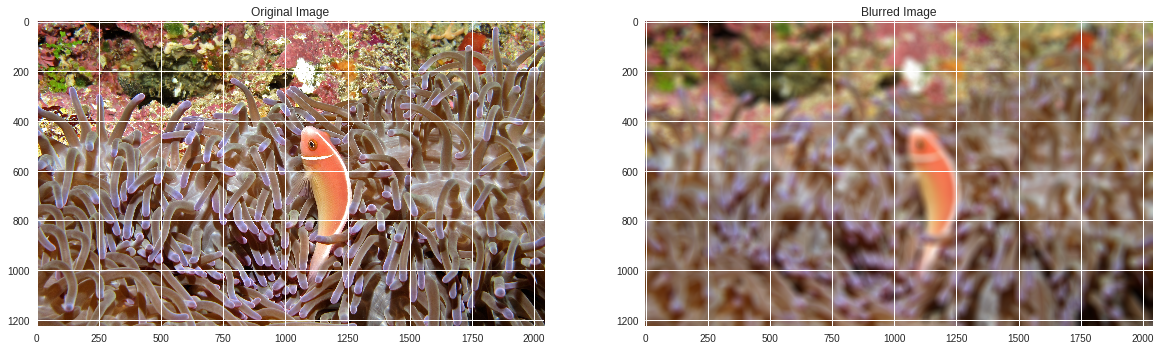

In [6]:
# Clip out a sample image to play with
tmp_img = plt.imread(DATA_ROOT+"/"+img_list[0])
#tmp_img = tmp_img[1:1+256,2:2+256].transpose(2,0,1) #CHW
tmp_img = tmp_img.transpose(2,0,1) #CHW

# Create a disk with the specified input radius. Values are binary
radius=20
d = disk(radius)

plt.imshow(d,cmap="gray")
plt.title("Disk with radius={}".format(radius))
plt.grid(False)

# Calculate the proper value of each disk element
val = 1/(math.pi*radius**2)

# Put the proper values on the disk
d = np.where(d>0, val, d)

print("Disk Shape: ",d.shape)
print("Disk max: ", d.max())
print("Disk min: ", d.min())

# Convolve the disk with the input image. Do the gamma correction atomically, i.e.
#  encode the image before convolving with the disk then decode the result of the 
#  convolution immediately.
gamma = 1
disk_filter = np.array([np.copy(d)])
out = scipy.ndimage.convolve(np.copy(tmp_img)**(gamma), disk_filter)**(1./gamma)

print("Image Shape: ",tmp_img.shape)
print("Disk Filter Shape: ",disk_filter.shape)
print("Output Shape: ",out.shape)
print("img.max: ",tmp_img.max())
print("img.min: ",tmp_img.min())
print("Out.max: ",out.max())
print("Out.min: ",out.min())


plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(tmp_img.transpose(1,2,0))
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(out.transpose(1,2,0))
plt.title("Blurred Image")
plt.show()

From above, we see that the blurred image looks reasonable and there are no unusual artifacts from the manual blur function. Now, we can copy this code into a function called ```manual_defocus``` so it can be used repeadedly. Then we can iterate through the HD dataset and create our full defocused dataset.

[0/50] Processing: drive/My Drive/DIV2K_train_HR/0298.png
Full Frame Shape:  (3, 512, 512)
	[0/50] Defocusing a fullframe with blur radius=24.0...


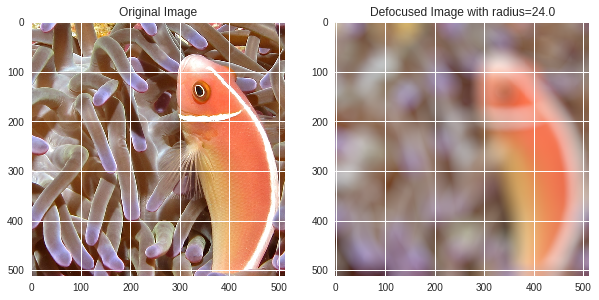

	[1/50] Defocusing a fullframe with blur radius=14.0...
	[2/50] Defocusing a fullframe with blur radius=5.0...
	[3/50] Defocusing a fullframe with blur radius=29.0...
	[4/50] Defocusing a fullframe with blur radius=7.0...
	[5/50] Defocusing a fullframe with blur radius=28.0...
	[6/50] Defocusing a fullframe with blur radius=15.0...
	[7/50] Defocusing a fullframe with blur radius=27.0...
	[8/50] Defocusing a fullframe with blur radius=13.0...
	[9/50] Defocusing a fullframe with blur radius=12.0...


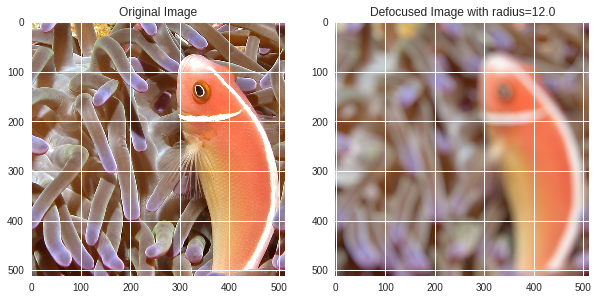

	[10/50] Defocusing a fullframe with blur radius=8.0...
	[11/50] Defocusing a fullframe with blur radius=4.0...
	[12/50] Defocusing a fullframe with blur radius=19.0...
	[13/50] Defocusing a fullframe with blur radius=0.0...
	[14/50] Defocusing a fullframe with blur radius=1.0...
	[15/50] Defocusing a fullframe with blur radius=0.0...
	[16/50] Defocusing a fullframe with blur radius=27.0...
	[17/50] Defocusing a fullframe with blur radius=30.0...
	[18/50] Defocusing a fullframe with blur radius=21.0...
	[19/50] Defocusing a fullframe with blur radius=26.0...


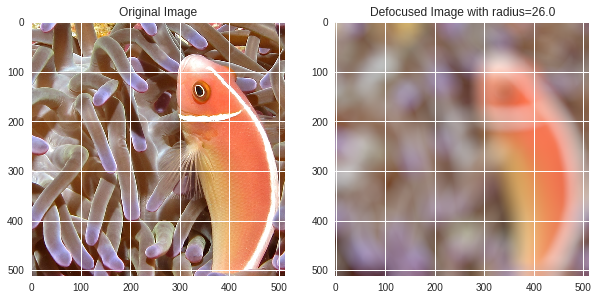

	[20/50] Defocusing a fullframe with blur radius=18.0...
	[21/50] Defocusing a fullframe with blur radius=0.0...
	[22/50] Defocusing a fullframe with blur radius=27.0...
	[23/50] Defocusing a fullframe with blur radius=24.0...
	[24/50] Defocusing a fullframe with blur radius=24.0...
	[25/50] Defocusing a fullframe with blur radius=8.0...
	[26/50] Defocusing a fullframe with blur radius=27.0...
	[27/50] Defocusing a fullframe with blur radius=11.0...
	[28/50] Defocusing a fullframe with blur radius=26.0...
	[29/50] Defocusing a fullframe with blur radius=6.0...
	[30/50] Defocusing a fullframe with blur radius=12.0...
	[31/50] Defocusing a fullframe with blur radius=13.0...
	[32/50] Defocusing a fullframe with blur radius=23.0...
	[33/50] Defocusing a fullframe with blur radius=19.0...
	[34/50] Defocusing a fullframe with blur radius=16.0...
	[35/50] Defocusing a fullframe with blur radius=30.0...
	[36/50] Defocusing a fullframe with blur radius=17.0...
	[37/50] Defocusing a fullframe wi

In [8]:
# Manual defocus function using disk function. The input img CHW in [0,255]
def manual_defocus(img, radius, gamma=2.4):
  
  #print("img shape: ",img.shape)
  #print("img max: ",img.max())
  
  if radius == 0.:
    return img,None
  
  # Create a disk with the specified input radius. Values are binary
  d = disk(radius)

  # Calculate the proper value of each disk element
  val = 1/(math.pi*radius**2)

  # Put the proper values on the disk filter
  d = np.where(d>0, val, d)

  # Convolve the disk with the input image. Do the gamma correction atomically, i.e.
  #  encode the image before convolving with the disk then decode the result of the 
  #  convolution immediately.
  disk_filter = np.array([np.copy(d)])
  out = 255.*scipy.ndimage.convolve(np.copy(img/255.)**(gamma), disk_filter)**(1./gamma)
  out = np.clip(out,0.,255.) # Otherwise weird things happen in the integer conversion
  
  # Since we are in [0,255] convert back to integers
  out = out.astype(np.uint8)
  
  return out, disk_filter

def crop_center(img,cropx,cropy):
  y,x,_ = img.shape
  startx = x//2-(cropx//2)
  starty = y//2-(cropy//2)    
  return img[starty:starty+cropy,startx:startx+cropx]

# Arrays to hold dataset
x_full = []
y_full = []

done=False
cnt = 0
MAX_IMG_CNT=50

# For each full frame HD image
for idx,img in enumerate(img_list):
  
  # Load in the full frame RGB image in CHW. Crop the biggest possible square
  #   out of the center for efficiency.
  img_path = DATA_ROOT+"/"+img
  full_frame = plt.imread(img_path)
  height,width,_ = full_frame.shape
  #full_frame = crop_center(full_frame,min(height,width),min(height,width))
  full_frame = crop_center(full_frame,512,512)
  full_frame = full_frame.transpose(2,0,1)

  print("[{}/{}] Processing: {}".format(idx, MAX_IMG_CNT, img_path))
  print("Full Frame Shape: ",full_frame.shape)
  
  # Create multiple training examples from each image, each will be defocused differently
  NUM_EACH_FF = 50
  for c in range(NUM_EACH_FF):
    
    # Count the number of full frames we have handled
    cnt += 1
    
    # Get random (Z_0, Z_i, r, alpha) from defocus model
    ind_hist=[]
    ind = np.random.choice(range(len(deFocusModel)),size=1)[0]
    z_0=10000;z_i=0
    while (ind in ind_hist) or (abs(z_0-z_i)>300):
      ind = np.random.choice(range(len(deFocusModel)),size=1)[0]
      z_0, z_i, r, alpha = deFocusModel[ind]
    ind_hist.append(ind)
    z_0, z_i, r, alpha = deFocusModel[ind]
    
    # Manually defocus the image. Input is CHW [0,255], Output is CHW [0,255]
    print("\t[{}/{}] Defocusing a fullframe with blur radius={}...".format(c,NUM_EACH_FF,r))
    defocused_image,_ = manual_defocus(255.*np.copy(full_frame), r)

    # Tile the full frame into all possible tsize x tsize patches
    t_size=256
    defocused_image = defocused_image.transpose(1,2,0) # Back to HWC for center cropping
    center_tile = crop_center(defocused_image,256,256)
    #tiles = np.array([np.copy(defocused_image[x:x+t_size,y:y+t_size]) for x in range(0,defocused_image.shape[0],t_size) for y in range(0,defocused_image.shape[1],t_size)])

    # Print a sample
    if cnt in [1,10,20]:
      plt.figure(figsize=(10,10))
      plt.subplot(1,2,1)
      plt.imshow(full_frame.transpose(1,2,0))
      plt.title("Original Image")
      plt.subplot(1,2,2)
      plt.imshow(defocused_image)
      plt.title("Defocused Image with radius={}".format(r))
      plt.show()
      
    # Add each tile to the training dataset
    #for j in range(len(tiles)):
    #  if tiles[j].shape == (t_size,t_size,3):
    x_full.append(np.copy(center_tile).transpose(2,0,1)) # Save as CHW
    y_full.append(abs(z_0-z_i))
        
    # Save every once in a while
    if cnt % 50 == 0:
      print("Saving current dataset...")
      x_data = np.stack(x_full, axis=0)
      y_data = np.array(y_full)
      np.save("drive/My Drive/hw4_training_images_v2.npy", x_data)
      np.save("drive/My Drive/hw4_training_labels_v2.npy", y_data)
  
       
  print("Finished frame processing... size of dataset={}".format(len(x_full)))
 
  # Early Exit?   
  if idx > MAX_IMG_CNT:
    break

assert(len(x_full) == len(y_full))

print("Saving final datasets...")
x_data = np.stack(x_full, axis=0)
y_data = np.array(y_full)
np.save("drive/My Drive/hw4_training_images_v2.npy", x_data)
np.save("drive/My Drive/hw4_training_labels_v2.npy", y_data)

Wow, that took an obscenely long time. Note, in this homework we tried several methods of dataset generation. The above method shows us only choosing to defocus image with a small blur radius but we also generated another dataset where we allowed for the full blur range.

Note: After experimentation, we chose to use the full blur range dataset for our final defocusing results. However, the results and visualizations look identical.

## Load the dataset

In [9]:
data_full = np.load("drive/My Drive/hw4_training_images_v2.npy")
label_full = np.load("drive/My Drive/hw4_training_labels_v2.npy")

print("Data shape: ",data_full.shape)
print("Label shape: ",label_full.shape)

Data shape:  (2600, 3, 256, 256)
Label shape:  (2600,)


## Format dataset

To format the dataset we split the full dataset into 90% train and 10% validation. We then format the images as float32 data with range [0,1]. After this we are ready to define the model and train.

In [10]:
# Create a validation split of 10% of full dataset
full_size = len(data_full)
validation_size = int(full_size*0.1)
val_inds = np.random.choice(range(full_size), size=validation_size, replace=False)
train_inds = np.array([int(x) for x in range(full_size) if x not in val_inds])
assert(set(val_inds).isdisjoint(train_inds))

# Create the splits
x_train = np.array([data_full[x] for x in train_inds])
y_train = np.array([label_full[x] for x in train_inds])
x_val = np.array([data_full[x] for x in val_inds])
y_val = np.array([label_full[x] for x in val_inds])

print("# train: ", train_inds.shape)
print("# val: ", val_inds.shape)
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)
print("x_val.shape: ",x_val.shape)
print("y_val.shape: ",y_val.shape)

# normalize data
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
print(np.max(x_train[0]))
x_train /= 255.
x_val /= 255.
print(np.max(x_train[0]))

# train:  (2340,)
# val:  (260,)
x_train.shape:  (2340, 3, 256, 256)
y_train.shape:  (2340,)
x_val.shape:  (260, 3, 256, 256)
y_val.shape:  (260,)
251.0
0.9843137


**Visualize some training samples**

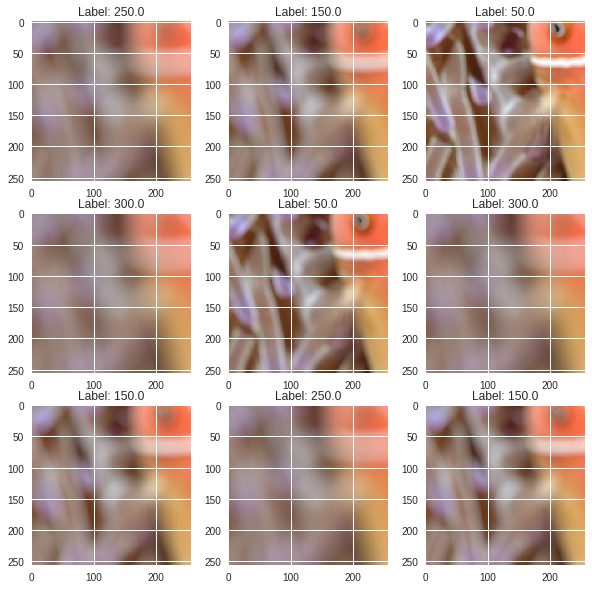

In [11]:
# Plot some samples
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(np.copy(x_train[i]).transpose(1,2,0))
  plt.title("Label: {}".format(y_train[i]))
plt.show()

## DNN Training

Now that our dataset is ready we can define the model architecture for the focus DNN. This is based on the architecture from "Intelligent Auto Focus" with some minor changes to the conv-1 filters and to the FC layers. Because our images are 256x256 rather than 512x512, we changed the kernel and stride of conv-1 as to not downsample so quickly. Since the feature maps are smaller as a result of the smaller input image, we also changed the FC layers to have less nodes. The below architecture was shown to work well. Also, the loss function is mean squared error and the optimizer is Adam.

In [0]:
# Step Estimator Model from "Intelligent Auto Focus" paper
def step_estimator_model():
    model = Sequential()
    # CONV-1
    model.add(Conv2D(filters=4, kernel_size=6, strides=4, activation='relu', input_shape=(3,256,256)))
    # CONV-2
    model.add(Conv2D(filters=8, kernel_size=4, strides=4, activation='relu'))
    # CONV-3
    model.add(Conv2D(filters=8, kernel_size=4, strides=4, activation='relu'))
    # Flatten
    model.add(Flatten())
    # FC-1
    model.add(Dense(64, activation='relu'))
    # FC-2
    model.add(Dense(32, activation='relu'))
    # FC-3
    model.add(Dense(1))

    # Define training functions
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam)
    return model

In [14]:
cnn_n = step_estimator_model()
cnn_n.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 63, 63)         436       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 15, 15)         520       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 3, 3)           1032      
_________________________________________________________________
flatten_1 (Flatten)          (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4672      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dens

### Train the DNN

With the architecture specified, we train the model for 1k epochs, validating after each epoch. The weights are saved to the drive.

In [0]:
chkpt = 'drive/My Drive/HW4_step_estimator_weights_v2.hdf5'
cp_cb = keras.callbacks.ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [16]:
cnn_n.fit(x_train, y_train, batch_size=32, epochs=1000, validation_data=(x_val,y_val), callbacks=[cp_cb], shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 2340 samples, validate on 260 samples
Epoch 1/1000
2340/2340 [==============================] - 5s 2ms/step - loss: 31012.2358 - val_loss: 32878.4972

Epoch 00001: val_loss improved from inf to 32878.49724, saving model to drive/My Drive/HW4_step_estimator_weights_v2.hdf5
Epoch 2/1000
2340/2340 [==============================] - 2s 841us/step - loss: 26751.6530 - val_loss: 21286.9690

Epoch 00002: val_loss improved from 32878.49724 to 21286.96899, saving model to drive/My Drive/HW4_step_estimator_weights_v2.hdf5
Epoch 3/1000
2340/2340 [==============================] - 2s 803us/step - loss: 12472.1519 - val_loss: 10851.7114

Epoch 00003: val_loss improved from 21286.96899 to 10851.71145, saving model to drive/My Drive/HW4_step_estimator_weights_v2.hdf5
Epoch 4/1000
2340/2340 [==============================] - 2s 753us/step - loss: 10319.4225 - val_loss: 10820.5622

Epoch 00004: val_loss improved from 10851.71145 to 10820.56220, s

### Visualize training results

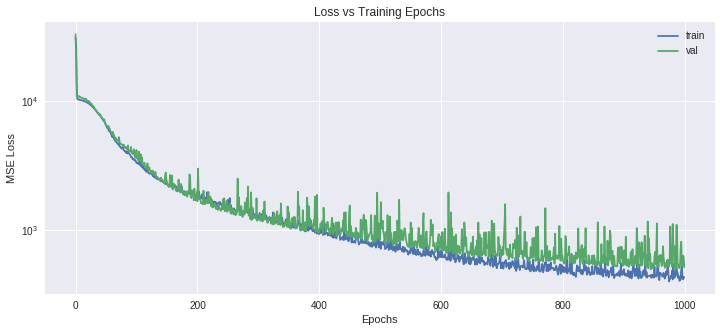

In [17]:
plt.figure(figsize=(12,5))
#plt.subplot(1,1,1)
plt.plot(cnn_n.history.history['loss'],label='train')
plt.plot(cnn_n.history.history['val_loss'],label='val')
plt.legend()
plt.title("Loss vs Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.show()

After 1k epochs, both the training and validation loss has appeared saturate at almost two orders of magnitude below the initial loss. The final step is to show some predictions from the validation set to see how good the model is.

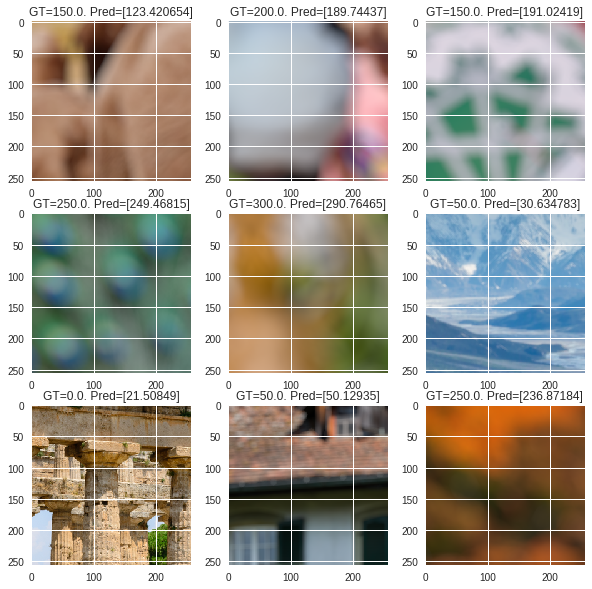

In [18]:
plt.figure(figsize=(10,10))
for jj in range(9):
  N = np.random.randint(low=0,high=len(y_val))
  eg1 = cnn_n.predict(np.expand_dims(x_val[N],axis=0))
  plt.subplot(3,3,jj+1)
  plt.imshow(np.copy(x_val[N]).transpose(1,2,0))
  plt.title("GT={}. Pred={}".format(y_val[N], eg1[0]))
plt.show()

From the above, the predictions are all reasonable. The clearly blurred images are predicted with high step values and the clear images yield low step count predictions.

Now, the model is saved so we will pick back up in the "Training" notebook.